# Laboratorio 2

## Teoría
1. **Indique cuál es costo de “Training” y de test del algoritmo KNN.**


2. **Explique porqué se dice que instance learning es un algoritmo por fuerza bruta o perezoso.**


3. **Indique cuantas comparaciones se deben realizar en la etapa de testeo (asumiendo el peor de los casos).**


4. **Investigue alguna modificación que se ha realizado al algoritmo original del KNN.**

## Realizando un clasificador de múltiples clases

### Distancia entre elementos

1. **Se debe de implementar un criterio de cómo elegir la clase de una muestra tomando en cuenta los k vecinos más cercanos. En el código se muestra el método “Uniforme”(la mayoría de elementos de una misma clase es la que gana). La idea es que se implemente otro método tomando en cuenta la distancia entre los elementos (distinto a $l_1$ y $l_2$). Este código debe implementarse dentro del método “predict” (en el if de distance). En el PDF se debe explicar en un diagrama en qué consiste el algoritmo implementado. Es importante destacar que la métrica puede ser inventada por cada grupo}**

In [27]:
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time

In [15]:
class KNearestNeighbors():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform', alpha=0.1):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights
        self.alpha = alpha #parametro para ponderado exponencial

        self.n_classes = 3

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def cosine_distance(self, a, b):
        a_norm = a / (np.linalg.norm(a) + 1e-8)
        b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-8)
        return 1 - np.sum(a_norm * b_norm, axis=1)

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []

#         print(X_test, self.X_train. X_test, self.X_train)
        point_dist = []
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def predict(self, X_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            #print("Y_pred: ", y_pred)
            return y_pred

        if self.weights == 'distance':

            dist, neigh_ind = self.kneighbors(X_test, return_distance=True)

            exp_weights = np.exp(-self.alpha * dist)
    
            normalized_weights = exp_weights / np.sum(exp_weights, axis=1)[:, np.newaxis]

            proba = []

            for i, row in enumerate(normalized_weights):

                row_pred = self.y_train[neigh_ind[i]]

                for k in range(self.n_classes):
                    indices = np.where(row_pred == k)
                    prob_ind = np.sum(row[indices])
                    proba.append(np.array(prob_ind))

            predict_proba = np.array(proba).reshape(X_test.shape[0],
                                                    self.n_classes)

            y_pred = np.array([np.argmax(item) for item in predict_proba])

            return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test)), y_pred, y_test

    def precision(self, y_test, y_pred):
        return


2. **Pruebe el algoritmo del punto anterior con k=2,3,4,5,6,7,9,11. Anote la precisión y el tiempo que se obtuvo para cada k. Además, compare los resultados obtenidos de su implementación con los de la biblioteca sklearn.**

In [16]:
dataset = datasets.load_iris(as_frame=True)

X = dataset.data
y = dataset.target

In [33]:
if isinstance(X, pd.DataFrame):
    X = X.to_numpy()
    y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(\
                X, y, test_size=0.3,stratify=y, random_state=45)



our_classifier = KNearestNeighbors(X_train, y_train, n_neighbors=7, weights="distance")
sklearn_classifier = KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train)

tiempo_inicio_oc = time.time()
our_accuracy, y_pred, y_test = our_classifier.score(X_test, y_test)
tiempo_fin_oc = time.time()

tiempo_inicio_sklearn = time.time()
y_pred_sklearn = sklearn_classifier.predict(X_test)
sklearn_accuracy = sklearn_classifier.score(X_test, y_test)
tiempo_fin_sklearn = time.time()

#preicision
precision_oc = precision_score(y_test, y_pred, average="micro")
precision_sklearn = precision_score(y_test, y_pred_sklearn, average="micro")

print(y_pred[:20], y_test[:20])
print(f'Tiempo de predicción de modelo propio: {tiempo_fin_oc - tiempo_inicio_oc} segundos --- Precisión: {precision_oc}')
print(f'Tiempo de predicción de modelo de Scikit Learn: {tiempo_fin_sklearn - tiempo_inicio_sklearn} segundos--- Precisión: {precision_sklearn}')

pd.DataFrame([[our_accuracy, sklearn_accuracy]],
             ['Accuracy'],    
             ['Our Implementation', 'Sklearn\'s Implementation'])

[1 0 2 0 0 2 0 2 1 0 1 1 1 0 2 2 1 0 1 2] [1 0 2 0 0 2 0 2 1 0 1 1 1 0 2 2 1 0 1 2]
Tiempo de predicción de modelo propio: 0.0023970603942871094 segundos --- Precisión: 0.9555555555555556
Tiempo de predicción de modelo de Scikit Learn: 0.003470897674560547 segundos--- Precisión: 0.9333333333333333


,Our Implementation,Sklearn's Implementation
Accuracy,0.955556,0.933333


3. **Realice una gráfica de k vr accuracy, de tal manera que le permita discutir los resultados obtenidos.**

k=2, accuracy=0.9333
k=3, accuracy=0.9111
k=4, accuracy=0.9111
k=5, accuracy=0.9333
k=6, accuracy=0.9333
k=7, accuracy=0.9556
k=8, accuracy=0.9333
k=9, accuracy=0.9556
k=10, accuracy=0.9333
k=11, accuracy=0.9556


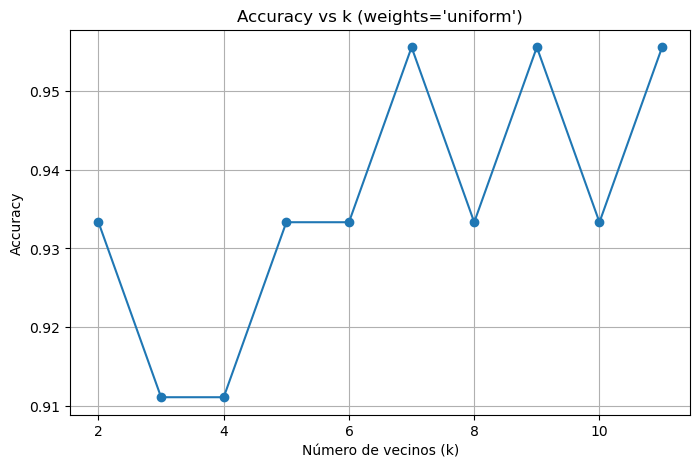

[0.9333333333333333,
 0.9111111111111111,
 0.9111111111111111,
 0.9333333333333333,
 0.9333333333333333,
 0.9555555555555556,
 0.9333333333333333,
 0.9555555555555556,
 0.9333333333333333,
 0.9555555555555556]

In [20]:
def evaluate_k_range(k_values=range(2,12), weights="distance"):
    
    accuracies = []

    for k in k_values:
        
        model = KNearestNeighbors(X_train, y_train, n_neighbors=k, weights="distance")

        acc, _, _ = model.score(X_test, y_test)
        accuracies.append(acc)
        print(f"k={k}, accuracy={acc:.4f}")

    
    plt.figure(figsize=(8,5))
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel("Número de vecinos (k)")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs k (weights='{weights}')")
    plt.grid(True)
    plt.show()

    return accuracies
evaluate_k_range()

### Clasificador de múltiples clases

1. **Cargue el set datos MNIST (dígitos), utilizando la biblioteca sklearn MNIST. En el listing 1 se muestra cómo hacerlo**

In [ ]:
#Listing 1
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits = load_digits(n_class=10)

2. **Muestre las primeras 12 imágenes en forma de tabla (3x4). Se debe de observar la imagen del dígito.**

3. **Muestre las dimensiones del set datos (cuántos datos y cuántos features).**

4. **Separe el set de datos de tal manera que el 75\% de los datos sea para entrenamiento, mientras que el 25\% sea para el test.**

5. **Instancie su propia implementación de KNN y pruebe el clasificador (k=2,3,5,7,8,10,11) con el set datos solicitados (note que son 10 clases). Muestre el accuracy con el método normal y con el método de distancia implementado por cada grupo.**

6. **Instancie el clasificador de sklearn y realice las mismas pruebas que el punto anterior.**

7. **Compare en una tabla la implementación propia del knn con el de la biblioteca sklearn.**

8. **Realice 5 imágenes con dígitos escrito a mano. Saque una foto a cada dígito y transforme la imagen a las mismas dimensiones que el set de datos. Pruebe su modelo prediciendo cada una de las fotos tomadas. Reporte la clasificación que brinda el modelo mostrando la imagen original y la clasificación obtenida.**